# importing the Data


In [69]:
import sys
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import warnings

def load_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        #Url
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=("datasets"))
    return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_data()


In [70]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [71]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Note: Total bedrooms are less than others and missing values , will fix that later using imputer

In [72]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Function to Save FIGS ;)

In [73]:
IMAGES_ROOT_DIR = Path() / "images" / "housing_project_figures"
IMAGES_ROOT_DIR.mkdir(parents=True, exist_ok=True) #if not exist

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """" SAVES THE PLOTS TO THE DIRECTORY """
    try:
        path = IMAGES_ROOT_DIR / f"{fig_id}.{fig_extension}"
        if tight_layout:
            plt.tight_layout()
        plt.savefig(path, format=fig_extension, dpi=resolution)
        print(f"Successfully saved plot to {path}")
    except Exception as e:
        warnings.warn(f"Error saving plot '{fig_id}': {e}")

# Getting Started with EDA(Exploratory Data Analysis)

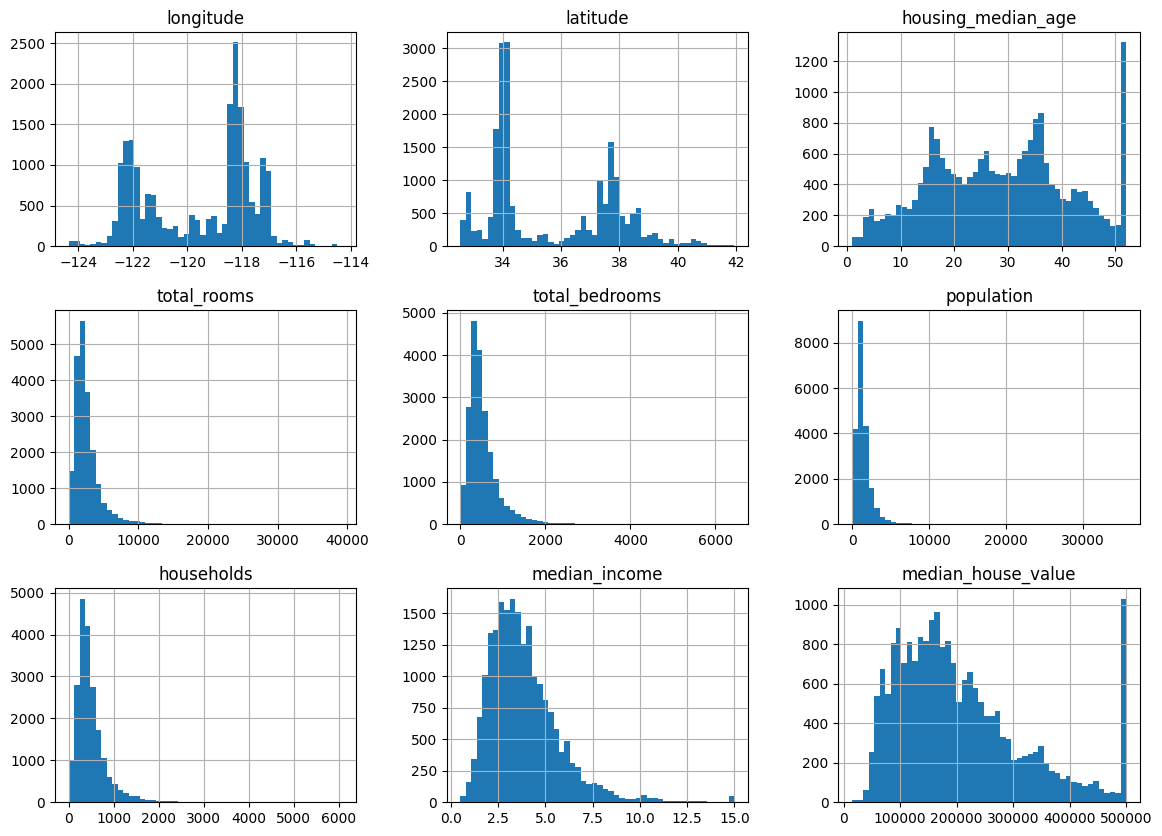

Successfully saved plot to images/housing_project_figures/housing_hist.png


<Figure size 640x480 with 0 Axes>

In [74]:
housing.hist(bins=50, figsize=(14,10))
plt.show()
save_fig("housing_hist")

Here , we. can see various attributes that might afftect the pricing of the house , it might be dependednt on location , income , size or population desnity , but we need to find and chosse the best features and find the correlation between them

# Splitting The Dataset into Training and Test

In [75]:
from sklearn.model_selection import train_test_split
train_set ,test_set = train_test_split(housing, test_size=0.2, random_state=42)

after splitting the dataset , we find median income of house would be the one that might affect the housing prices so , since they are skewed in dataset as shown by graph most of the income lies to left side , so we can convert into categories so it doent overgeneralise the data.

In [76]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6.0,np.inf], labels=[1,2,3,4,5])

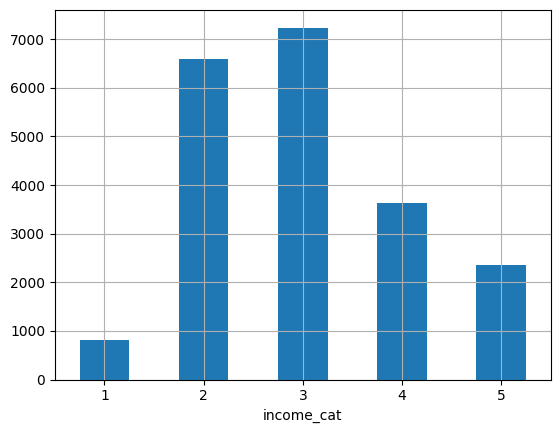

Successfully saved plot to images/housing_project_figures/housing_cat_income.png


<Figure size 640x480 with 0 Axes>

In [77]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.show()
save_fig("housing_cat_income")

now we can see when its converted into Categories and would be benefecial for our model. but their is a better way to do that using strattified split

In [78]:
#the hard way
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])

In [79]:
strat_train_set, strat_test_set =strat_splits[0]

In [80]:
#the easy way
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [81]:
#verification
strat_test_set["income_cat"].value_counts() /len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

lets see the Difference b/w Random and strat data


In [82]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() /len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare = pd.DataFrame({
    "Overall %" : income_cat_proportions(housing),
    "Stratified %" : income_cat_proportions(strat_test_set),
    "Random %" : income_cat_proportions(test_set),
}).sort_index()

compare.index.name = "Income Categories"
compare["Strat. Error %"] = (compare["Stratified %"]/compare["Overall %"] - 1 )
compare["Random Error %"] = (compare["Random %"] / compare["Overall %"] - 1)

(compare*100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Random Error %
Income Categories,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


hence , the normal train test split skews the dataset and the error range is more with it , but with stratified it support better .
we can drop the income cat column now we dont need it anymore


In [83]:
#drop income_cat from both the sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# EDA

In [84]:
housing = strat_train_set.copy()

In [85]:
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


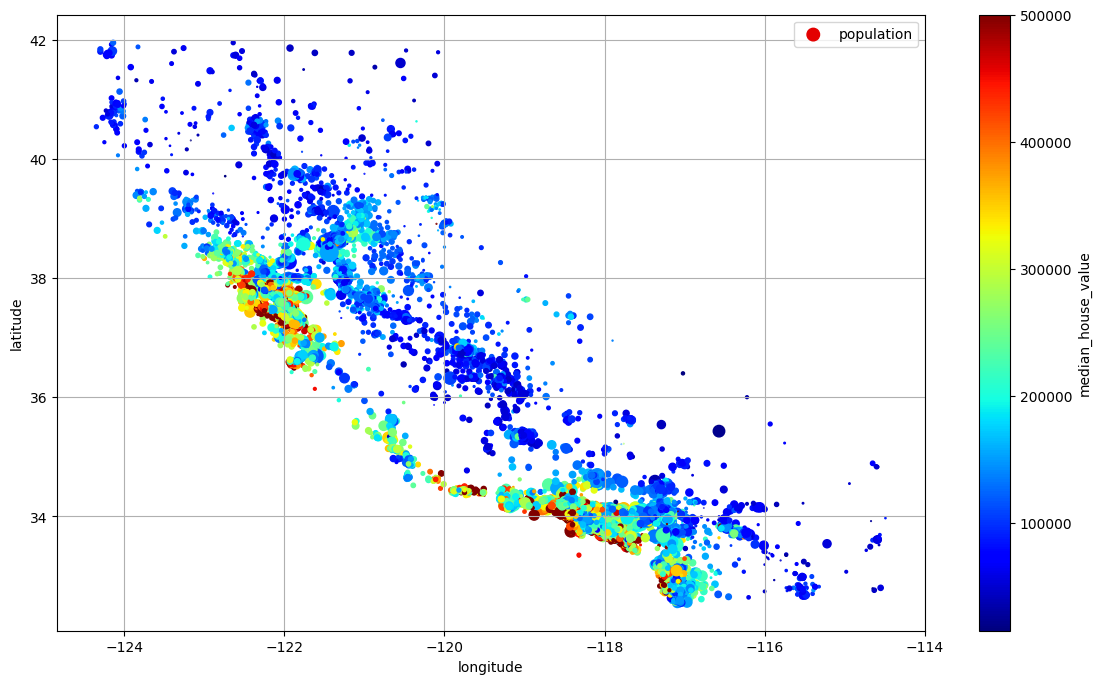

Successfully saved plot to images/housing_project_figures/geo_plot.png


<Figure size 640x480 with 0 Axes>

In [88]:
housing.plot(kind = "scatter" ,x="longitude", y="latitude",
            s= housing["population"]/100, label= "population",
            c="median_house_value",
            cmap="jet", colorbar=True,
            legend=True, sharex=False, grid =True, figsize=(14,8))
plt.show()
save_fig("geo_plot")